In [1]:
%matplotlib notebook
import numpy as np

# digit dataset
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt

# measure time execution
import time

# scikit-learn classifiers
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# look for best hyperparamters by cross validation
from sklearn import grid_search

# compute performances classifier
from sklearn.metrics import confusion_matrix,accuracy_score

# split data into training and test
from sklearn.cross_validation import train_test_split

np.random.seed(seed=42)

# Import data

In [2]:
#Load labelled digit data
digits = load_digits()
X, y = digits.data, digits.target

# Bench classifiers

In [7]:
# define a fonction that takes estimator as argument and outputs time execution and test score
def bench(name,clf,Xtrain,ytrain,Xtest,ytest):
    # train
    t0 = time.time()
    clf.fit(Xtrain,ytrain)
    time_train = time.time()-t0
    # test
    t0 = time.time()
    ypred = clf.predict(Xtest)
    time_test = time.time()-t0
    # score
    score = accuracy_score(ytest, ypred)
    cf_matrix = confusion_matrix(ytest, ypred)*1.0/np.bincount(ytest)[:,np.newaxis]
    return name,score,time_train,time_test,cf_matrix

# find best k for knn using grid_search
clf_knn_grid = grid_search.GridSearchCV(KNeighborsClassifier(), {'n_neighbors': [1,2,3,4,5,6,7,8,9,10] },cv=5)
clf_knn_grid.fit(X,y)

k_scores = [x[1] for x in clf_knn_grid.grid_scores_]
print "*** knn cross-validation scores for different k : "
print k_scores
k_best = clf_knn_grid.best_params_['n_neighbors']
print "*** knn cross-validation best score for k = ",k_best,' ( score=',clf_knn_grid.best_score_,')'

# launch bench() on various estimators for 21% test data
clf_list = dict()
clf_list['LDA               '] = LinearDiscriminantAnalysis()
clf_list['LogisticRegression'] = LogisticRegression()
clf_list['QDA               '] = QuadraticDiscriminantAnalysis()
clf_list['KNN               '] = KNeighborsClassifier()
clf_list['KNN best          '] = clf_knn_grid.best_estimator_
results = []

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.21, random_state=0)

results = []
for name in clf_list:
    clf = clf_list[name]
    print "*** currently processing ",name,"..."
    results.append(bench(name,clf,Xtrain,ytrain,Xtest,ytest))


*** knn cross-validation scores for different k : 
[0.96494156928213692, 0.96661101836393992, 0.96605453533667218, 0.96382860322760155, 0.96271563717306619, 0.95937673900946019, 0.95993322203672793, 0.95770728992765719, 0.95603784084585419, 0.95492487479131882]
*** knn cross-validation best score for k =  2  ( score= 0.966611018364 )
*** currently processing  LDA                ...
*** currently processing  LogisticRegression ...
*** currently processing  KNN                ...
*** currently processing  QDA                ...
*** currently processing  KNN best           ...


In [8]:
# display results
print "*"*68
print "* classifier          * score     * train time (s) * test time (s) *"
print "*"*68
for r in results:
    print "*"*68
    print "*",r[0]," * %0.5f   * %0.5f        * %0.5f       *" % (r[1],r[2],r[3])
print "*"*68


********************************************************************
* classifier          * score     * train time (s) * test time (s) *
********************************************************************
********************************************************************
* LDA                 * 0.95503   * 0.01156        * 0.00037       *
********************************************************************
* LogisticRegression  * 0.94974   * 0.27531        * 0.00267       *
********************************************************************
* KNN                 * 0.97619   * 0.00235        * 0.12317       *
********************************************************************
* QDA                 * 0.89683   * 0.04224        * 0.00524       *
********************************************************************
* KNN best            * 0.98148   * 0.00233        * 0.10779       *
********************************************************************


- Le **KNN** a le temps de training le plus court, ce qui n'est pas etonnant car ce classifieur n'a aucun calcul de paramètres à réaliser. En revanche, il a le temps de test le plus long car il calcule un grand nombre de distance (Ntrain) qu'il doit en plus partiellement mettre dans l'ordre pour selectionner la plus petite.
- Le temps de training du **LDA** est plus court que celui du **QDA**, car le LDA inverse une seule matrice (celle de variance-covariance supposé commune à toutes les classes) alors que le QDA inverse 10 matrices (celles propre à chaque classe) 
- La **Regression Logistique** a le temps de training le plus long car face à un probleme multi classe, scikit fait une descente de gradient par la methode de Newton (*'newton-cg'*) ou de quasi-Newton (*'lbfgs'*) où il faut approximer un Hessien (très couteux) à chaque itération. En revanche, ce classifieur a un temps de test court car il s'agit d'une simple convolution suivi d'un logit.

# Confusion matrix

In [9]:
scores = np.asarray([r[1] for r in results])
ind_min = scores.argmin()
ind_max = scores.argmax()
np.set_printoptions(precision=3)
print "\n*** confusion matrix for worst score (",results[ind_min][0],",%0.5f) : \n" % results[ind_min][1]
print results[ind_min][4]
print "\n*** confusion matrix for best score (",results[ind_max][0],",%0.5f) : \n" % results[ind_max][1]
print results[ind_max][4]


*** confusion matrix for worst score ( QDA                ,0.89683) : 

[[ 1.     0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.971  0.029  0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.189  0.757  0.     0.     0.     0.     0.     0.027  0.027]
 [ 0.     0.     0.     0.906  0.     0.     0.     0.     0.094  0.   ]
 [ 0.     0.     0.     0.     0.818  0.     0.     0.182  0.     0.   ]
 [ 0.     0.     0.     0.     0.     1.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.022  0.978  0.     0.     0.   ]
 [ 0.     0.025  0.     0.     0.     0.     0.     0.975  0.     0.   ]
 [ 0.     0.119  0.024  0.024  0.     0.     0.     0.024  0.81   0.   ]
 [ 0.     0.     0.     0.024  0.024  0.071  0.     0.071  0.048  0.762]]

*** confusion matrix for best score ( KNN best           ,0.98148) : 

[[ 1.     0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     1.     0.     0.     0.     0.     0.    

Le mauvais classifieur se trompe majoritairement sur le chiffre "2", qu'il confond avec un "1" :

<IPython.core.display.Javascript object>


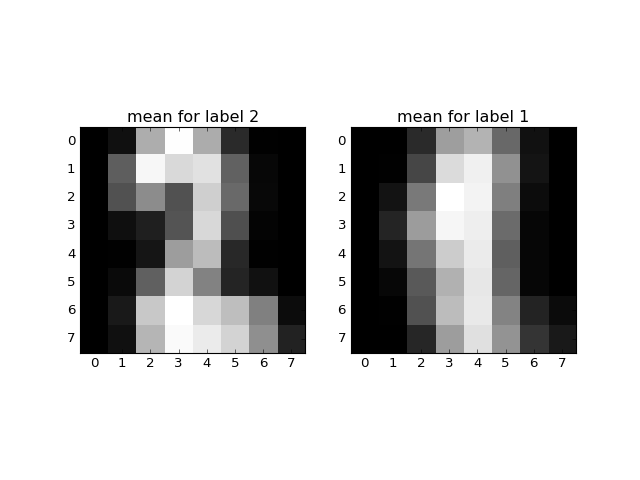

In [10]:
fig = plt.figure()
for i,l in enumerate((2,1)):
    ax = fig.add_subplot(1,2,i+1)
    ax.imshow(np.reshape(np.mean(X[y==l,:],axis=0),(8,8)), cmap=plt.cm.gray, interpolation='nearest')
    ax.set_title("mean for label "+str(l))

# Graphes

<IPython.core.display.Javascript object>


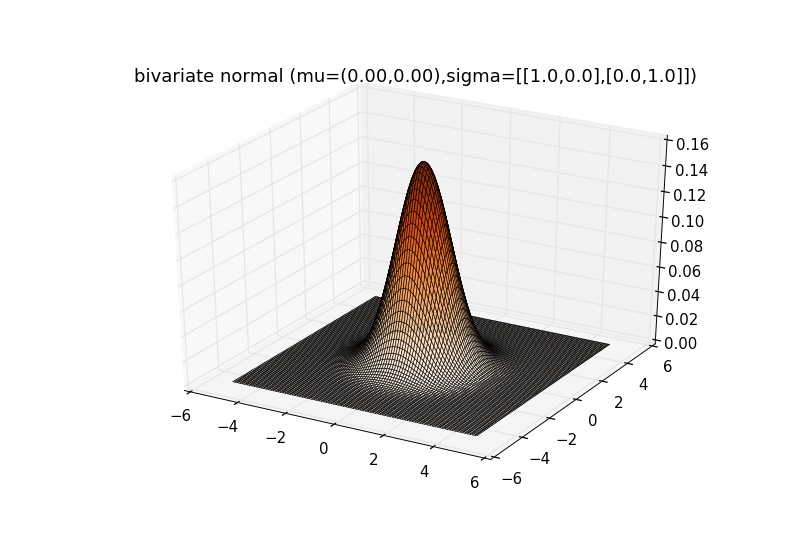

<IPython.core.display.Javascript object>


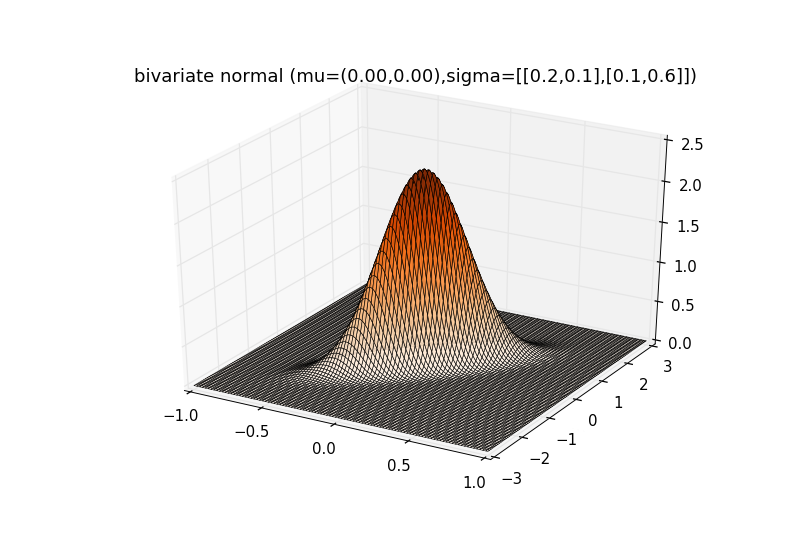

In [49]:
from mpl_toolkits.mplot3d import Axes3D

def plot_bivariate(sigma,mu):
    if(sigma[0,1] != sigma[1,0]):
        print "Error : Variance-Covariance matrix should be symmetric"
        return
    step = 300
    xx = np.linspace(mu[0]-5*sigma[0,0], mu[0]+5*sigma[0,0], step)
    yy = np.linspace(mu[1]-5*sigma[1,1], mu[1]+5*sigma[1,1], step)
    Xg, Yg = np.meshgrid(xx, yy)
    Z = plt.mlab.bivariate_normal(Xg, Yg, sigmax=sigma[0,0], sigmay=sigma[1,1],
                                mux=mu[0], muy=mu[1], sigmaxy=sigma[0,1])
    fig2 = plt.figure(figsize=(9, 6), dpi = 90)
    ax = fig2.add_subplot(111, projection='3d')
    ax.plot_surface(Xg, Yg, Z, cmap='Oranges',rstride=3, cstride=3, alpha=0.9, linewidth=0.5)
    plt.title("bivariate normal (mu=(%.2f,%.2f),sigma=[[%.1f,%.1f],[%.1f,%.1f]])" % (mu[0],mu[1],sigma[0,0],sigma[0,1],sigma[1,0],sigma[1,1]))
    
    return plt

mu = np.asarray([0,0])
sigma1 = np.asarray([[0.2,0.1],[0.1,0.2]])
sigma2 = np.asarray([[0.2,0.1],[0.1,0.6]])
plot_bivariate(sigma,mu)
plt.show()
plot_bivariate(sigma2,mu)
plt.show()


    